In [69]:
import pandas as pd
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [70]:
df = pd.read_csv("Source data/veterinary_data.csv") 
df.head(5)


,ID,Owner,Animal,Animal_Type,Age,State,Diagnoses,Treatment
0,1,John Doe,Max,Dog,5,California,Arthritis,Anti-inflammatory drugs
1,2,Jane Smith,Whiskers,Cat,3,Texas,Upper respiratory infection,Antibiotics
2,3,Bob Johnson,Polly,Bird,2,New York,Feather plucking,Behavioral therapy
3,4,Alice Brown,Luna,Dog,7,Florida,Dental disease,Teeth cleaning
4,5,Mike Wilson,Bubbles,Fish,1,Nevada,Fin rot,Salt bath and medication


Check for Missing or Inconsistent Data

In [71]:
print(df["Diagnoses"].unique())
print(df["State"].unique())

['Arthritis' 'Upper respiratory infection' 'Feather plucking'
 'Dental disease' 'Fin rot' 'GI stasis' 'Skin allergy' 'Fleas'
 'Metabolic bone disease' 'Heartworm']
['California' 'Texas' 'New York' 'Florida' 'Nevada' 'Oregon' 'Washington'
 'Ohio' 'Georgia' 'Colorado']


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           100 non-null    int64 
 1   Owner        100 non-null    object
 2   Animal       100 non-null    object
 3   Animal_Type  100 non-null    object
 4   Age          100 non-null    int64 
 5   State        100 non-null    object
 6   Diagnoses    100 non-null    object
 7   Treatment    100 non-null    object
dtypes: int64(2), object(6)
memory usage: 6.4+ KB


In [73]:
df = df.drop_duplicates()


EXPLORATIVE DATA ANALYSIS

In [74]:
print(df.describe())

               ID        Age
count  100.000000  100.00000
mean    50.500000    6.45000
std     29.011492    4.16909
min      1.000000    1.00000
25%     25.750000    3.00000
50%     50.500000    5.00000
75%     75.250000   10.00000
max    100.000000   14.00000


In [75]:
print(df["Animal_Type"].value_counts())
print(df["State"].value_counts())


Animal_Type
Dog       20
Fish      20
Rabbit    19
Cat       18
Bird      12
Lizard    11
Name: count, dtype: int64
State
Georgia       16
Florida       12
Oregon        12
Colorado      12
Washington    10
California     8
New York       8
Ohio           8
Texas          7
Nevada         7
Name: count, dtype: int64


VISUALIZE DATA

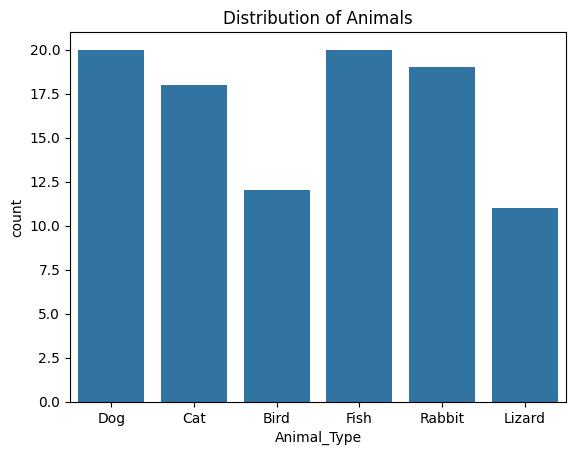

In [76]:
#Animal type distribution

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Animal_Type", data=df)
plt.title("Distribution of Animals")
plt.show()


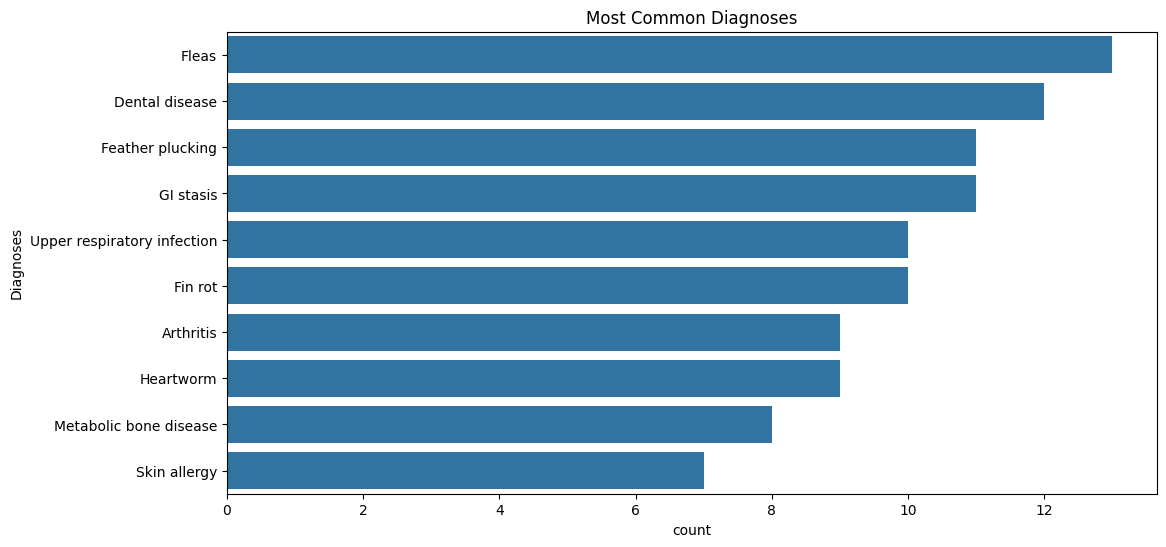

In [77]:
#
plt.figure(figsize=(12,6))
sns.countplot(y="Diagnoses", data=df, order=df["Diagnoses"].value_counts().index)
plt.title("Most Common Diagnoses")
plt.show()


**DATA INSIGHTS AND PATTERNS**


In [78]:
#Most common health issues by specie

diagnosis_counts = df.groupby("Animal_Type")["Diagnoses"].value_counts()

# Get the most common diagnosis for each animal type
most_common_diagnosis = diagnosis_counts.groupby(level=0).idxmax()
most_common_diagnosis_counts = diagnosis_counts.groupby(level=0).max()

# Combine the results into a DataFrame
result_df = pd.DataFrame({"Most Common Diagnosis": most_common_diagnosis, "Count": most_common_diagnosis_counts})

# Reset index for better readability
result_df.reset_index(inplace=True)

# Display the result
print(result_df)

  Animal_Type   Most Common Diagnosis  Count
0        Bird       (Bird, GI stasis)      2
1         Cat          (Cat, Fin rot)      5
2         Dog        (Dog, Arthritis)      3
3        Fish  (Fish, Dental disease)      3
4      Lizard       (Lizard, Fin rot)      2
5      Rabbit     (Rabbit, GI stasis)      4


In [79]:
# State wise distribution illness

df.groupby("State")["Diagnoses"].value_counts()
# print(df.groupby("State")["Diagnoses"].value_counts().unstack())

State       Diagnoses                  
California  Fleas                          2
            GI stasis                      2
            Arthritis                      1
            Dental disease                 1
            Fin rot                        1
                                          ..
Washington  Heartworm                      2
            Upper respiratory infection    2
            Fleas                          1
            Metabolic bone disease         1
            Skin allergy                   1
Name: count, Length: 66, dtype: int64

In [80]:
#Effective treatment

df.groupby("Diagnoses")["Treatment"].value_counts()
# print(df.groupby("Diagnoses")["Treatment"].value_counts().sort_values(ascending=False

Diagnoses                    Treatment                 
Arthritis                    Salt bath and medication      3
                             Anti-inflammatory drugs       2
                             Antibiotics                   1
                             Antihistamines                1
                             Calcium supplements           1
                                                          ..
Upper respiratory infection  Anti-inflammatory drugs       1
                             Calcium supplements           1
                             Dietary changes and fluids    1
                             Flea treatment                1
                             Heartworm treatment           1
Name: count, Length: 68, dtype: int64

**ADVANCED ANALYSIS**

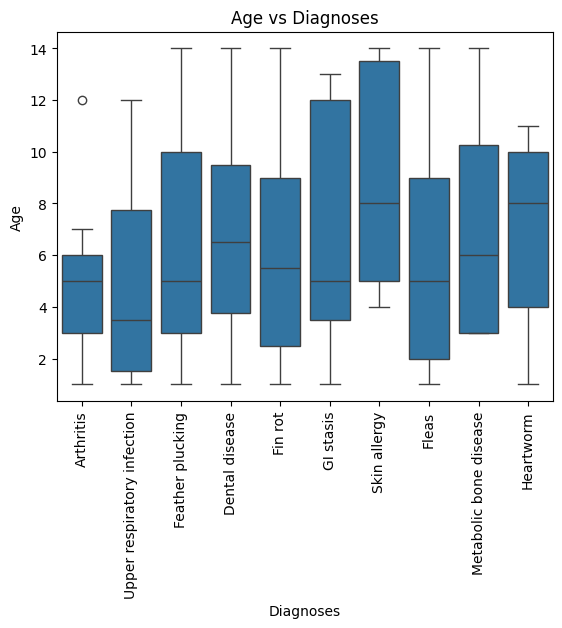

In [81]:
#Correlation between age and diseases

sns.boxplot(x="Diagnoses", y="Age", data=df)
plt.xticks(rotation=90)
plt.title("Age vs Diagnoses")
plt.show()


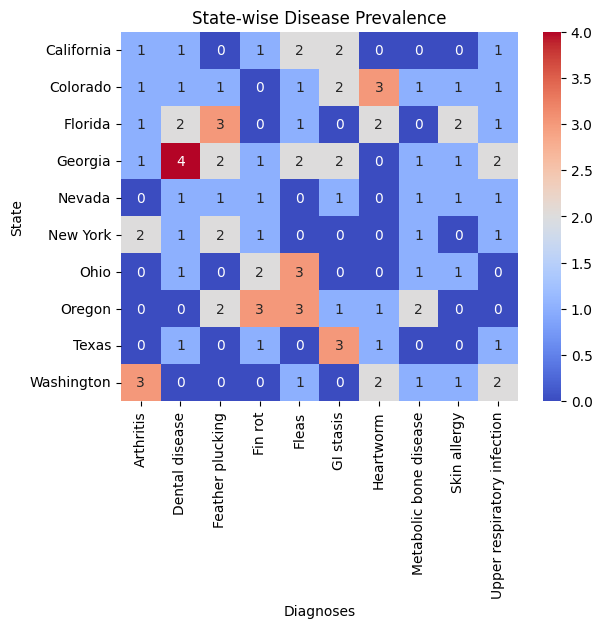

In [82]:
#State wise prevalent certain disease

disease_pivot = df.pivot_table(index="State", columns="Diagnoses", aggfunc="size", fill_value=0)
sns.heatmap(disease_pivot, cmap="coolwarm", annot=True, fmt="d")
plt.title("State-wise Disease Prevalence")
plt.show()


**Can we predict the treatment based on diagnoses?**

In [83]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression


In [84]:
print(df.columns)


Index(['ID', 'Owner', 'Animal', 'Animal_Type', 'Age', 'State', 'Diagnoses',
       'Treatment'],
      dtype='object')


In [85]:

# 🚨 One-Hot Encode Diagnoses
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_diagnoses = pd.DataFrame(encoder.fit_transform(df[["Diagnoses"]]))

# Set column names properly
encoded_diagnoses.columns = encoder.get_feature_names_out(["Diagnoses"])
df = df.join(encoded_diagnoses).drop(columns=["Diagnoses"])  # Remove original Diagnoses column

# ✅ Select Only Diagnoses Features
X = df.filter(like="Diagnoses_")
y = df["Treatment"]

# 🚨 Check if X is still empty
if X.empty:
    raise ValueError("🚨 No valid 'Diagnoses_' columns found! Check dataset preprocessing.")

# Convert target variable to numeric if needed
if y.dtype not in [np.int64, np.float64]:
    y = y.astype("category").cat.codes

# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Model
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Evaluate Model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("🚀 Basic Model Accuracy:", accuracy)


🚀 Basic Model Accuracy: 0.1
